# __IMDB REVIEW SENTIMENT PREDICTION by LOGISTIC REGRESSION__
## _Source: <a href='https://www.imdb.com/'> IMDb.com </a>_
<img src="https://images-eu.ssl-images-amazon.com/images/I/315W5zxAnTL.png" alt="drawing" width="200"/>






## __INTRODUCTION to DATASET__
__What is IMDb?__

IMDb is an online database of information related to films, television programs, home videos, video games, and streaming content online – including cast, production crew and personal biographies, plot summaries, trivia, fan and critical reviews, and ratings.

__What is the dataset about?__

The dataset is about all of the viewer's movie review on IMDb platform and their sentiment.

## __GOAL of the PROJECT__
The project aims to the target using LOGISTIC REGRESSION for building a model to predict the sentiments of review on IMDb.

Target accuracy: 90%

## __EXPLORATORY DATA ANALYSIS__

* Import the data and necessary library

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [0]:
#Import the train data
data = pd.read_csv('/content/drive/My Drive/Machine Learning - Tonga - Coder School 2020/FTMLE - Tonga/Data/movie_review.csv',sep='\t')

In [0]:
#Import the evaluation data
data_evaluation = pd.read_csv('/content/drive/My Drive/Machine Learning - Tonga - Coder School 2020/FTMLE - Tonga/Data/movie_review_evaluation.csv',sep='\t')

* Show data sample: 

In [0]:
data.head(5)

,id,review,sentiment
0,5814_8,With all this stuff going down at the moment w...,1
1,2381_9,"\The Classic War of the Worlds\"" by Timothy Hi...",1
2,7759_3,The film starts with a manager (Nicholas Bell)...,0
3,3630_4,It must be assumed that those who praised this...,0
4,9495_8,Superbly trashy and wondrously unpretentious 8...,1


In [0]:
data_evaluation.head(5)

,id,review
0,10633_1,I watched this video at a friend's house. I'm ...
1,4489_1,`The Matrix' was an exciting summer blockbuste...
2,3304_10,This movie is one among the very few Indian mo...
3,3350_3,The script for this movie was probably found i...
4,1119_1,Even if this film was allegedly a joke in resp...


* Show data information: 
  * There are 22500 reviews in totals
  * The sentiments indicated by 2 interger values 0 and 1

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22500 entries, 0 to 22499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         22500 non-null  object
 1   review     22500 non-null  object
 2   sentiment  22500 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 527.5+ KB


* Define features data and labels

In [0]:
X = data['review']
X_validation = data_evaluation['review']
y = data['sentiment']

## __BUILD MODEL__

### __STEP 1: VECTORIZATION__

#### __DATA CLEANING__

* Preprocessing

This function will remove the unnecessary character in text like punctuation but still keep the emoticons

In [0]:
import re
def preprocessor(text):
  text = re.sub('<[^>]*>', '', text)
  # question_mark = re.findall('[£$]',text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = re.sub('[^A-Za-z0-9]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', '')#+' '.join(question_mark)
  return text

* Remove the stop word

Stop words are words that do not give any meaning to the sentences so need to be removed

In [0]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* Tokenizing

There are several ways for tokenizing the data: Stemmer, Lemmatizer. Those ways will reduce number of words by combining the words that have similar meaning

In [0]:
def tokenizer(text):
    return text.split()

In [0]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()
def tokenizer_porter(text):
  return [porter.stem(word) for word in text.split()]

In [0]:
nltk.download('wordnet')
from nltk import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def tokenizer_lemmatizer(text):
  return [lemmatizer.lemmatize(word) for word in text.split()]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### __VECTORIZING__



* CountVectorizer

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

ngam_vect = CountVectorizer(ngram_range=(1,3), tokenizer=tokenizer_porter, preprocessor=preprocessor)

* TfidfVectorizer

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=tokenizer_porter, preprocessor=preprocessor, ngram_range=(1,3))

* Doc2Vec

In [0]:
# Data cleaning for Doc2Vec
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def imdb_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()
data['review_doc2vec'] = data['review'].apply(imdb_cleaner)

In [0]:
train_doc2vec, test_doc2vec = train_test_split(data, test_size=0.2, random_state=42)
import nltk
from nltk.corpus import stopwords
from gensim.models.doc2vec import TaggedDocument
nltk.download('punkt')
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['review_doc2vec']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['review_doc2vec']), tags=[r.sentiment]), axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

### __STEP 2: TRAIN MODEL WITH LOGISTIC REGRESSION__

* With GridSearc (Search for the optimized parameter of vectorizer)

In [0]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


param_grid = [{'vect__ngram_range': [(1, 2),(1,3)],
               'vect__stop_words': [None],
               'vect__binary' :[False,True]
               'vect__tokenizer': [tokenizer_lemmatizer, tokenizer_porter],
               'vect__preprocessor': [preprocessor],
               'vect__max_iter' : [100,200]
               'clf__penalty': [None, 'l2'],
               'clf__C': [1.0, 0.5, 0.1]},
              ]

lr_ngam_vect = Pipeline([('vect', ngam_vect),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_ngam_vect = GridSearchCV(lr_ngam_vect, param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           n_jobs=8)
gs_lr_ngam_vect.fit(X, y)

In [0]:
pd.DataFrame(gs_lr_tfidf.cv_results_).sort_values('rank_test_score').head(5)

* CountVectorizer

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2)

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

clf = Pipeline([('vect', ngam_vect),('clf',LogisticRegression(random_state=0))])

In [103]:
%%time
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

CPU times: user 4min 5s, sys: 39.5 s, total: 4min 44s
Wall time: 3min 48s


In [104]:
# Model Accuracy
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
print("Mean Squared Error: %f" % mean_squared_error(y_test, predictions))
print("Accuracy Score: %f" % accuracy_score(y_test, predictions))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Mean Squared Error: 0.102000
Accuracy Score: 0.898000
Confusion Matrix:
[[2007  244]
 [ 215 2034]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2251
           1       0.89      0.90      0.90      2249

    accuracy                           0.90      4500
   macro avg       0.90      0.90      0.90      4500
weighted avg       0.90      0.90      0.90      4500



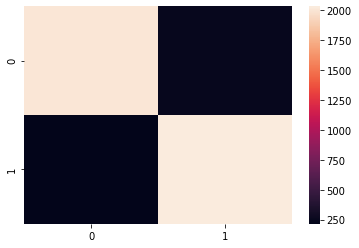

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt

Confusion_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(Confusion_matrix)
plt.show()

* TfidfVectorizer

In [0]:
clf_tfidf = Pipeline([('vect', tfidf),('clf',LogisticRegression(random_state=0))])
clf_tfidf.fit(X_train, y_train)
predictions_tfidf = clf_tfidf.predict(X_test)

In [107]:
# Model Accuracy
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
print("Mean Squared Error: %f" % mean_squared_error(y_test, predictions_tfidf))
print("Accuracy Score: %f" % accuracy_score(y_test, predictions_tfidf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions_tfidf))
print(classification_report(y_test, predictions_tfidf))

Mean Squared Error: 0.120000
Accuracy Score: 0.880000
Confusion Matrix:
[[1946  305]
 [ 235 2014]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      2251
           1       0.87      0.90      0.88      2249

    accuracy                           0.88      4500
   macro avg       0.88      0.88      0.88      4500
weighted avg       0.88      0.88      0.88      4500



* Doc2Vec

In [108]:
%%time
import multiprocessing
cores = multiprocessing.cpu_count()
# model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow = Doc2Vec(dm=0, size=500, negative=5, min_count=1, workers=cores, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 18000/18000 [00:00<00:00, 2760116.70it/s]


CPU times: user 10min 42s, sys: 5.77 s, total: 10min 48s
Wall time: 5min 53s


In [109]:
%%time
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(C=0.5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
predictions_doc2vec = logreg.predict(X_test)

CPU times: user 5min 13s, sys: 563 ms, total: 5min 13s
Wall time: 5min 13s


In [110]:
# Model Accuracy
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
print("Mean Squared Error: %f" % mean_squared_error(y_test, predictions_doc2vec))
print("Accuracy Score: %f" % accuracy_score(y_test, predictions_doc2vec))
print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions_doc2vec))
print(classification_report(y_test, predictions_doc2vec))

Mean Squared Error: 0.107556
Accuracy Score: 0.892444
Confusion Matrix:
[[1967  232]
 [ 252 2049]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      2199
           1       0.90      0.89      0.89      2301

    accuracy                           0.89      4500
   macro avg       0.89      0.89      0.89      4500
weighted avg       0.89      0.89      0.89      4500



## __VALIDATION__

CountVecterizer show the highest accuracy

In [112]:
%%time
clf.fit(X, y)
predictions = clf.predict(X_validation)

CPU times: user 4min 43s, sys: 40.5 s, total: 5min 24s
Wall time: 4min 25s


In [133]:
pd.concat([X_validation,pd.Series(predictions,name='sentiment')],axis=1)['sentiment'].value_counts()

0    1260
1    1240
Name: sentiment, dtype: int64

In [0]:
pd.concat([X_validation,pd.Series(predictions,name='sentiment')],axis=1).to_csv('validation_imdb.csv')